<a href="https://colab.research.google.com/github/Fish210/3470-Competition-Team-Optimization-Model/blob/main/compTeamOptModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using CSV: ranked_team2025.csv

Initial label counts:
label_selected
0    16
1    14
Name: count, dtype: int64

Final label counts (auto-fixed):
label_selected
0    16
1    14
Name: count, dtype: int64

Split type: 80/20 split (safe default)
Train labels:
 label_selected
0    13
1    11
Name: count, dtype: int64
Test labels:
 label_selected
0    3
1    3
Name: count, dtype: int64

Confusion Matrix:
 [[3 0]
 [0 3]]

Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


Files exported. Download from the Files panel.


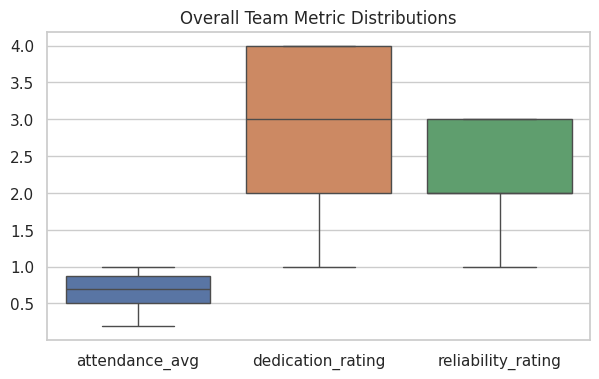

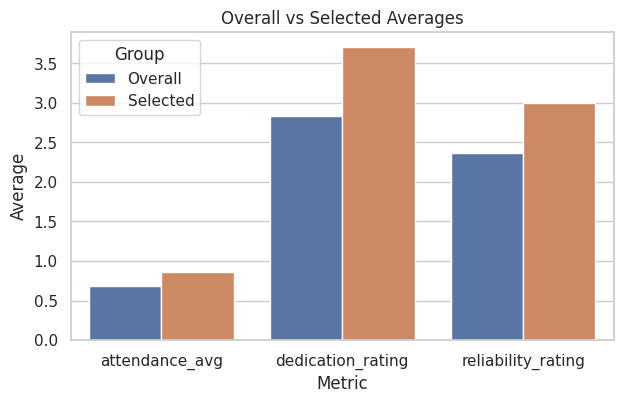

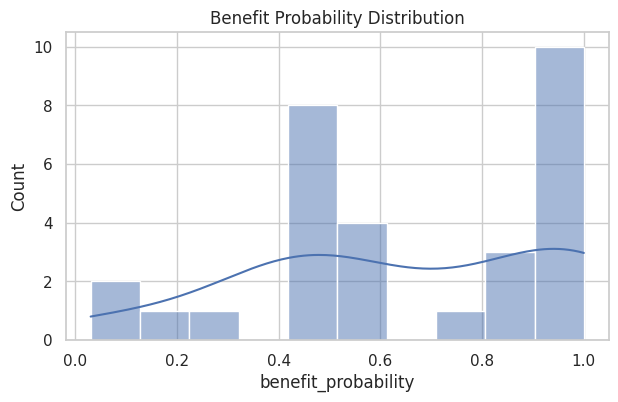

In [ ]:
#FTC RANDOM FOREST Machine Learning Model
#Developers: John Uy & Vishvak Gurram
#Date: December 15, 2025

#Imports
import pandas as pd
import numpy as np
import glob, os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style="whitegrid")

#SETTINGS

FORCE_CSV_NAME = None
TEST_EVENTS = None # e.g. ["randomEvent1"] or ["randomEvent1","randomEvent2"] or None for auto-pick -- IMPORTANT!!
TARGET_EVENTS = None # e.g. ["randomEvent1"] or ["randomEvent1","randomEvent2"] or None for auto-pick -- IMPORTANT!!
FEATURES = ["attendance_avg", "dedication_rating", "reliability_rating"]
LABEL = "label_selected"
EXPORT_CSV = True
EXPORT_XLSX = True
##########
#Load CSV file
if FORCE_CSV_NAME:
    CSV_NAME = FORCE_CSV_NAME
else:
    csvs = sorted(glob.glob("*.csv"), key=os.path.getmtime)
    if not csvs:
        raise FileNotFoundError("Upload a CSV first.")
    CSV_NAME = csvs[-1]

print("Using CSV:", CSV_NAME)
df = pd.read_csv(CSV_NAME)
##########
#Clean!
REQUIRED = ["person_id", "event_id"] + FEATURES + [LABEL]
df = df[REQUIRED].copy()

for c in FEATURES + [LABEL]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df.dropna(inplace=True)
df[LABEL] = df[LABEL].astype(int)

print("\nInitial label counts:")
print(df[LABEL].value_counts())

#Force valid labels to ensure it always works

# Compute benefit score
att = df["attendance_avg"]                      # already 0–1
ded = (df["dedication_rating"] - 1) / 3         # normalize to 0–1
rel = (df["reliability_rating"] - 1) / 2        # normalize to 0–1

df["benefit_probability"] = (0.10 * att) + (0.45 * ded) + (0.45 * rel)
df["benefit_probability"] = df["benefit_probability"].round(2)


#Auto TOP_N so ALWAYS get both 0 and 1
n = len(df)
TOP_N = max(1, n // 2)   #half selected, half not

df[LABEL] = (df["benefit_probability"].rank(ascending=False) <= TOP_N).astype(int)

print("\nFinal label counts (auto-fixed):")
print(df[LABEL].value_counts())

##########
#Train / test split

split_type = "80/20 split (safe default)"

X = df[FEATURES]
y = df[LABEL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nSplit type:", split_type)
print("Train labels:\n", y_train.value_counts())
print("Test labels:\n", y_test.value_counts())

##########
#TRAIN MODEL!!!
model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"
)
model.fit(X_train, y_train)
##########
#Evaluate
pred = model.predict(X_test)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, pred))
print("\nReport:\n", classification_report(y_test, pred))

##########
#Rank target event
if TARGET_EVENTS is None:
    TARGET_EVENTS = [df["event_id"].iloc[-1]]

rank_df = df[df["event_id"].isin(TARGET_EVENTS)].copy()

#Determine benefit probability
rank_df["benefit_probability"] = rank_df["benefit_probability"].round(2)


rank_df = rank_df.sort_values("benefit_probability", ascending=False)

display_cols = ["person_id","event_id"] + FEATURES + ["benefit_probability",LABEL]
rank_df[display_cols].head(20) #Change number for top picks -- IMPORTANT!!

##########
#Export time!!!
safe_name = "_".join(TARGET_EVENTS).replace(" ", "_")

if EXPORT_CSV:
    rank_df[display_cols].to_csv(f"ranked_{safe_name}.csv", index=False)

if EXPORT_XLSX:
    rank_df[display_cols].to_excel(f"ranked_{safe_name}.xlsx", index=False)

print("\nFiles exported. Download from the Files panel.")

##########
#Visualize using SEABORN
plt.figure(figsize=(7,4))
sns.boxplot(data=df[FEATURES])
plt.title("Overall Team Metric Distributions")
plt.show()

avg_df = pd.DataFrame({
    "Overall": df[FEATURES].mean(),
    "Selected": df[df[LABEL]==1][FEATURES].mean()
}).round(2)

avg_df = avg_df.reset_index().melt(
    id_vars="index", var_name="Group", value_name="Average"
).rename(columns={"index":"Metric"})

plt.figure(figsize=(7,4))
sns.barplot(data=avg_df, x="Metric", y="Average", hue="Group")
plt.title("Overall vs Selected Averages")
plt.show()

plt.figure(figsize=(7,4))
sns.histplot(rank_df["benefit_probability"], bins=10, kde=True)
plt.title("Benefit Probability Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(data=rank_df, x=LABEL, y="benefit_probability")
plt.xticks([0,1],["Not Selected","Selected"])
plt.title("Model Scores vs Selection")
plt.show()
